In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pandas as pd

from sklearn import decomposition, preprocessing
from skimage.feature import greycomatrix, greycoprops
from skimage import exposure

## Feature engineering

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas to engineer new features used in this notebook, </span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl, with contributions by Daniel Kittridge,</span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. 

### 1 - create a list of geometric windows for rolling features

Facies are interpreted groupings of rocks and commonly composed of a several rock elements, each demonstrating different properties. Therefore, we should expect to see a distribution of WL log responses for each facies. A corollary of this is that attempting to directly solve for a facies with WL log responses at any given depth will be tenuous. Facies require a context; a context provided by the surrounding rock. Likewise, if we are to effectively solve for facies from WL logs, we should provide a context to for each response at a given depth. We can accomplish this with *rolling windows*.

A rolling window provides a local neighbourhood of values about a central point, which can be stepped through an array of values. The neighbourhood sample size, which is the depth thickness/sampling rate, of the neighbourhood evaluated should relate directly to the thickness of a facies. Because facies are observed with different thicknesses, we will build neighbourhoods to include the thickest observed facies. To keep the number of rolling windows reasonable, we will use a geometric function where the half window length is doubled for each subsequent value.

In [2]:
# import file
filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)

# eliminate nulls
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

# get facies
y = training_data['Facies'].values

# get longest facies 
max_len = max(len(list(s)) for (c,s) in itertools.groupby(y))
max_len

68

In [3]:
# function to create a geometric series of window sizes 
# using powers of 2 up to one just above a reference geological size (longest facies)

def geom_windows(max_sz): 
    """returns a list of square window sizes using powers of two"""
    return list(int(2**(n+1)+1) for n in np.arange(np.ceil(np.log2(max_sz))))

In [4]:
# window sizes
sizes = geom_windows(max_len)
sizes

[3, 5, 9, 17, 33, 65, 129]

### 2 -  moments feature generation

The simplest and most fundamental way to numerically describe the shape of a distribution of values is using [moments](http://www.statisticshowto.com/what-is-a-moment/). The first moment, [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html#numpy.mean) $\mu$, characterizes the central tendency of the distribution. The second moment, [variance](https://docs.scipy.org/doc/numpy/reference/generated/numpy.var.html#numpy.var) $\sigma^2$, characterizes the spread of the values about the central tendency. The third moment, [skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) $\gamma_1$, characterizes the symmetry (or lack thereof) about the central tendency.

We will calculate the first three moments (with one small modification) for each rolling window size at every depth. The small modification is that instead of variance $\sigma^2$, we are calculating standard deviation $\sigma$ because the results of variance $\sigma^2$ produce values with units of the mean squared $\mu^2$. As a result, feature importance of variance is artificially high due to the dimension of the variance values. Standard deviation $\sigma$ has the same dimension as mean $\mu$.

With respect to facies prediction, now, in addition to the raw WL log inputs, we will describe at multiple scales the shapes of the distributions of WL log responses associated with each facies.

In [1]:
# Efficient rolling statistics with NumPy
# http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [6]:
# function to calculate moments using a rolling window

def rollin_moments(arr, w, moment ='mean'):
    """- pad input array by (w-1)/2 samples at the top and bottom
       - apply rolling window function
       - calculate moment: mean (default), var, or skew"""
    mom = []
    arr = np.pad(arr, ((w-1)/2, (w-1)/2), 'edge')  
    if moment == 'std':
        return np.array(np.std(rolling_window(arr, w), 1))
    elif moment == 'skew':
        return np.array(sp.stats.skew(rolling_window(arr, w), 1))
    else:
        return np.array(np.mean(rolling_window(arr, w), 1))

In [7]:
moments=['mean', 'std', 'skew']

In [8]:
# re-import data and filling missing PE values with average

filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)

training_data['PE'].fillna((training_data['PE'].mean()), inplace=True)
print  np.shape(training_data)
training_data['PE'].fillna((training_data['PE'].mean()), inplace=True)
print  np.shape(training_data)

(4149, 11)
(4149, 11)


In [9]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000
mean,4.5033,2906.8674,64.9340,0.6596,4.4025,13.2011,3.7250,1.5184,0.5219
std,2.4743,133.3002,30.3025,0.2527,5.2749,7.1328,0.7909,0.4997,0.2866
min,1.0000,2573.5000,10.1490,-0.0259,-21.8320,0.5500,0.2000,1.0000,0.0000
25%,2.0000,2821.5000,44.7300,0.4980,1.6000,8.5000,3.2000,1.0000,0.2770
50%,4.0000,2932.5000,64.9900,0.6390,4.3000,12.0200,3.7250,2.0000,0.5280
75%,6.0000,3007.0000,79.4380,0.8220,7.5000,16.0500,4.0000,2.0000,0.7690
max,9.0000,3138.0000,361.1500,1.8000,19.3120,84.4000,8.0940,2.0000,1.0000


To keep feature importance on a level playing field, we will rescale each WL log before calculating moments. We will use [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [10]:
# standardize features to go into moments calculation
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [11]:
scaled_vectors_df = pd.DataFrame(scaled_features, columns=list(feature_vectors))
scaled_feat_df = pd.concat((training_data[['Depth', 'Well Name', 'Formation', 'Facies']], scaled_vectors_df),1)
scaled_feat_df.head()

,Depth,Well Name,Formation,Facies,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0000,SHRIMPLIN,A1 SH,3,0.4131,0.0175,1.0423,-0.1803,1.1064,-1.0376,1.6683
1,2793.5000,SHRIMPLIN,A1 SH,3,0.4398,0.0057,1.8576,-0.0892,0.4742,-1.0376,1.5950
2,2794.0000,SHRIMPLIN,A1 SH,3,0.4659,-0.0062,1.9714,-0.0212,-0.1581,-1.0376,1.5183
3,2794.5000,SHRIMPLIN,A1 SH,3,0.6986,-0.0181,1.8007,-0.0121,-0.2845,-1.0376,1.4450
4,2795.0000,SHRIMPLIN,A1 SH,3,0.3184,-0.0497,1.7249,0.0139,-0.4110,-1.0376,1.3717


In [12]:
# calculate all moments for all logs, for all wells

final_df = pd.DataFrame()             # final dataframe

grouped = training_data['Well Name'].unique()

for well in grouped:                  # for each well     
    new_df = pd.DataFrame()           # make a new temporary dataframe 
   
    for log in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND' ,'PE']:
        for mo in moments:            # for each moment
                                      # calculate the rolling moments with each window size
                                      # and also the mean of moments (all window sizes)
            results = np.array([rollin_moments(scaled_feat_df[log][scaled_feat_df['Well Name'] == well],
                                               size, moment = mo) for size in sizes])
            mean_result = np.mean(results, axis=0)
                                      # write to temporary dataframe 
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[0])] = results[0]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[1])] = results[1]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[2])] = results[2]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[3])] = results[3]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[4])] = results[4]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[5])] = results[5]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[6])] = results[6]
            new_df[str(log)+ '_' + str(mo)+'_wsize=ave'] = mean_result
                                      # append all rows of temporary dataframe to final dataframe          

    final_df = pd.concat([final_df, new_df])

In [13]:
final_df.describe()

,GR_mean_wsize=3,GR_mean_wsize=5,GR_mean_wsize=9,GR_mean_wsize=17,GR_mean_wsize=33,GR_mean_wsize=65,GR_mean_wsize=129,GR_mean_wsize=ave,GR_std_wsize=3,GR_std_wsize=5,...,PE_std_wsize=129,PE_std_wsize=ave,PE_skew_wsize=3,PE_skew_wsize=5,PE_skew_wsize=9,PE_skew_wsize=17,PE_skew_wsize=33,PE_skew_wsize=65,PE_skew_wsize=129,PE_skew_wsize=ave
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,...,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000
mean,-0.0000,0.0003,0.0007,0.0012,0.0020,0.0058,0.0235,0.0048,0.1579,0.2542,...,0.7163,0.4516,0.0210,0.0378,0.0458,0.0658,0.1263,0.1739,0.2244,0.0993
std,0.9616,0.9142,0.8249,0.6920,0.5254,0.3908,0.3570,0.5765,0.2251,0.3180,...,0.4618,0.3330,0.4521,0.5773,0.6270,0.6641,0.6752,0.6219,0.5662,0.3510
min,-1.7746,-1.7264,-1.6490,-1.5003,-1.2895,-1.0583,-1.0015,-1.2453,0.0002,0.0094,...,0.0000,0.0000,-1.0000,-1.5000,-2.4749,-3.3231,-4.1331,-2.4207,-2.8087,-1.4898
25%,-0.6317,-0.6244,-0.5697,-0.4635,-0.3208,-0.2104,-0.1733,-0.3910,0.0476,0.0850,...,0.3675,0.1999,-0.2883,-0.3079,-0.2344,-0.2307,-0.1231,-0.0225,0.0000,-0.0218
50%,0.0036,0.0100,0.0280,0.0129,-0.0182,0.0059,0.0222,0.0082,0.0929,0.1568,...,0.7977,0.4429,0.0000,0.0000,0.0000,0.0000,0.0000,0.0462,0.2203,0.0205
75%,0.4656,0.4494,0.4192,0.3744,0.3114,0.2160,0.2156,0.3134,0.1784,0.2972,...,1.0570,0.6720,0.3818,0.3632,0.3688,0.4000,0.4877,0.5521,0.5927,0.3244
max,8.7912,6.9026,5.3798,3.6272,3.1635,2.7984,2.6547,3.6996,3.3147,3.9119,...,1.7849,1.6715,1.0000,1.5000,2.4749,3.1863,3.1959,2.4672,2.3229,1.2788


### 2 - GLCM feature generation

Statistical moments can be said to characterize the composition of a neighbourhood of values. However, we can easily describe two neighbourhoods with identical composition that are distinctly different. For example *N1* = [00001111] and *N2* = [01010101] have exactly the same mean $\mu$, variance $\sigma^2$, and skewness $\gamma_1$, but, in terms of rocks, might represent different facies. Therefore, in addition to describing the shape of a distribution of values for a facies, we need something to evaluate the ordering of those values. That something is a grey-level coocurrence matrix (GLCM). 

A GLCM is a second order statistical method that numerically describes ordering of elements by evaluating the probability of values to be neighbours. Think of the GLCM as a histogram that preserves the ordering of values. For more about the GLCM, see Mryka Hall-Beyer's [tutorial](http://www.fp.ucalgary.ca/mhallbey/tutorial.htm) and read [skimage.feature.greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix) documentation. Just as we calculated moments to describe the shape of a histogram, we need to represent the arrangement of values in a GLCM with a single value. Properties that capture different characteristics of a GLCM including contrast, dissimilarity, homogeneity, ASM, energy, and correlation can be calculated with [skimage.feature.greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops). To keep resulting dimensions equivalent to the moments previously calculated, we will use the properties dissimilarity, energy, and correlation.

In [2]:
# function to calculate glcm and greycoprops using a rolling window

def gprops_calc(arr, w, lv, sym = True, prop='dissimilarity'):
    """- make w copies of the input array, roll it up one row at a time
       - calculate glcm on a square window of size w
       - calculate greycoprops from glcm: dissimilarity (default), energy, or correlation
       - repeat until back at row one
       N.B. the input array is padded by (w-1)/2 samples at the top and bottom"""
    diss = []
    itr = len(arr)
    arr = np.pad(arr, ((w-1)/2, (w-1)/2), 'edge')
    s = np.array([arr,]*w,dtype=np.uint8).transpose()
    for _ in np.arange(itr):
        if sym == True:
            glcm = greycomatrix(s[:w,:], [1], [np.pi/2], levels = lv, symmetric = True, normed = True)
        else:
            glcm = greycomatrix(s[:w,:], [1], [np.pi/2], levels = lv, symmetric = False, normed = True)
        if prop == 'correlation':
            ds = greycoprops(glcm, 'correlation')
        elif prop == 'energy':
            ds = greycoprops(glcm, 'energy')
        else:
            ds = greycoprops(glcm, 'dissimilarity')
        diss.append(ds)
        s = np.roll(s[:, :], -w)
    return np.ndarray.flatten(np.array(diss)) 

In [15]:
methods=['dissimilarity','energy', 'correlation']

Similar to the step preceeding moments calculation, we will rescale the raw WL logs for GLCM property calculation so each resulting property is unaffected by the magnitude of the raw WL log values. [skimage.feature.greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix) requires uint8 values, so we need an alternative to [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Unlike with calculating moments, preserving the shape of the histogram is not important to the integrity of a GLCM property. We will use [histogram equalization](http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html), which flattens a histogram (puts an equal number of values in each bin). To maximize the effectiveness of a GLCM, it is commonly wise to reduce the bit depth from 8 to avoid processing expense and noise caused by empty matrix entries. After some trial and error, we found the 64 bins works nicely. Note that 64 bins results in a *64x64* matrix at every depth for every rolling window size.

In [16]:
# functions to equalize histogram of features to go into GLCM calculation
def eqlz(arr, bins):
    return (bins-1) * exposure.equalize_hist(arr)
def eqlz_along_axis(arr, bins):
    return np.apply_along_axis(eqlz, 0, arr, bins)

In [17]:
# equalize features
feature_vectors_glcm = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
eq_vectors_glcm = eqlz_along_axis(feature_vectors_glcm, 64)

In [18]:
eq_vectors_glcm_df = pd.DataFrame(eq_vectors_glcm, columns=list(feature_vectors_glcm))
eq_vectors_glcm_df = np.round(eq_vectors_glcm_df).astype(int)
eq_glcm_df = pd.concat((training_data[['Depth', 'Well Name', 'Formation', 'Facies']], eq_vectors_glcm_df),1)
eq_glcm_df.head()

,Depth,Well Name,Formation,Facies,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0000,SHRIMPLIN,A1 SH,3,46,34,54,32,55,30,63
1,2793.5000,SHRIMPLIN,A1 SH,3,47,34,61,35,48,30,61
2,2794.0000,SHRIMPLIN,A1 SH,3,47,34,62,37,26,30,60
3,2794.5000,SHRIMPLIN,A1 SH,3,53,33,61,38,24,30,58
4,2795.0000,SHRIMPLIN,A1 SH,3,43,33,61,38,22,30,57


One last consideration for the GLCM is its symmetry. Symmetry in a GLCM refers to a bi-directional evaluation of the reference-neighbour pair. In plain English, if you were to construct a GLCM by hand, you would move through an array in one direction and then in the opposite direction. It is often desirable to do this because this removes the asymmety caused at the edge of a neighbourhood. See Mryka Hall-Beyer's [tutorial](http://www.fp.ucalgary.ca/mhallbey/tutorial.htm) for a full explanation of this. However, since sedimentary rocks (provided that they are structurally undisturbed) are laid down from bottom to top, we thought in, addition to the symmetric GLCM, it would be useful to evaluate the asymmetric GLCM where we look at the neighbour above.

First let's calculate symmetric GLCM properties:

In [19]:
final_df_glcm = pd.DataFrame()        # final dataframe
grouped = training_data['Well Name'].unique()

for well in grouped:                   # for each well   
    new_dfg = pd.DataFrame()           # make a new temporary dataframe 

    for log in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:   # for each log
        for me in methods:            # for each property
                                      # calculate rolling GLCM properties with each window size
                                      # and also the mean of moments (all window sizes)
            lg = eq_glcm_df[log][eq_glcm_df['Well Name'] == well]
            results = np.array([gprops_calc(lg.astype(int), wd, lv = 64, sym = True, prop = me) for wd in sizes])
            mean_result = np.mean(results, axis=0)
                                      # write to temporary dataframe 
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[0])] = results[0]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[1])] = results[1]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[2])] = results[2]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[3])] = results[3]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[4])] = results[4]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[5])] = results[5]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[6])] = results[6]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=ave'] = mean_result
                                      # append all rows of temporary dataframe to final dataframe 

    final_df_glcm  = pd.concat([final_df_glcm , new_dfg])

In [20]:
final_df_glcm.describe()

,GR_GLCM_dissimilarity_wsize=3,GR_GLCM_dissimilarity_wsize=5,GR_GLCM_dissimilarity_wsize=9,GR_GLCM_dissimilarity_wsize=17,GR_GLCM_dissimilarity_wsize=33,GR_GLCM_dissimilarity_wsize=65,GR_GLCM_dissimilarity_wsize=129,GR_GLCM_dissimilarity_wsize=ave,GR_GLCM_energy_wsize=3,GR_GLCM_energy_wsize=5,...,PE_GLCM_energy_wsize=129,PE_GLCM_energy_wsize=ave,PE_GLCM_correlation_wsize=3,PE_GLCM_correlation_wsize=5,PE_GLCM_correlation_wsize=9,PE_GLCM_correlation_wsize=17,PE_GLCM_correlation_wsize=33,PE_GLCM_correlation_wsize=65,PE_GLCM_correlation_wsize=129,PE_GLCM_correlation_wsize=ave
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,...,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000
mean,3.6655,3.6587,3.6478,3.6262,3.5938,3.5214,3.3838,3.5853,0.5572,0.4111,...,0.3571,0.4703,0.0791,0.4102,0.6635,0.8093,0.8790,0.9136,0.9294,0.6692
std,3.8264,2.9219,2.1691,1.6652,1.3437,1.1368,0.9819,1.6104,0.1114,0.0921,...,0.3527,0.2879,0.6409,0.4530,0.2956,0.1837,0.1229,0.0819,0.0553,0.2077
min,0.0000,0.0000,0.1250,0.4375,0.5000,0.9375,1.1641,0.7578,0.5000,0.3536,...,0.0806,0.2290,-1.0000,-1.0000,-0.5924,-0.1399,-0.0086,0.1382,0.5059,0.0809
25%,1.0000,1.5000,1.8750,2.3750,2.5938,2.6875,2.5703,2.3382,0.5000,0.3536,...,0.1174,0.2760,-0.3333,0.0338,0.4949,0.7214,0.8346,0.8855,0.9009,0.5314
50%,2.5000,2.7500,3.2500,3.5625,3.5312,3.4062,3.3750,3.2790,0.5000,0.3953,...,0.1508,0.3255,-0.1111,0.4667,0.7241,0.8514,0.9014,0.9221,0.9300,0.6392
75%,5.0000,5.0000,5.1250,4.6250,4.4375,4.2969,4.0625,4.4799,0.6124,0.4330,...,0.4579,0.4985,1.0000,0.6800,0.8770,0.9434,0.9635,0.9660,0.9623,0.7444
max,30.5000,20.0000,13.5000,9.9375,8.5000,7.6250,6.2188,10.6150,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


And now let's calculate asymmetric GLCM properties using only the upward neighbour:

In [21]:
final_df_glcm1 = pd.DataFrame()        # final dataframe
grouped1 = training_data['Well Name'].unique()

for well1 in grouped1:                   # for each well   
    new_dfg1 = pd.DataFrame()           # make a new temporary dataframe 

    for log1 in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:   # for each log
        for me in methods:            # for each property
                                      # calculate rolling GLCM properties with each window size
                                      # and also the mean of moments (all window sizes)
            lg1 = eq_glcm_df[log][eq_glcm_df['Well Name'] == well1]
            results1 = np.array([gprops_calc(lg1.astype(int), wd, lv = 64, sym = False, prop = me) for wd in sizes])
            mean_result1 = np.mean(results1, axis=0)
            
                                      # write to temporary dataframe 
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[0])] = results1[0]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[1])] = results1[1]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[2])] = results1[2]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[3])] = results1[3]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[4])] = results1[4]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[5])] = results1[5]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[6])] = results1[6]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=ave'] = mean_result1
                                      # append all rows of temporary dataframe to final dataframe 

    final_df_glcm1  = pd.concat([final_df_glcm1 , new_dfg1])

In [22]:
final_df_glcm1.describe()

,GR_GLCM_dissimilarity_asym_wsize=3,GR_GLCM_dissimilarity_asym_wsize=5,GR_GLCM_dissimilarity_asym_wsize=9,GR_GLCM_dissimilarity_asym_wsize=17,GR_GLCM_dissimilarity_asym_wsize=33,GR_GLCM_dissimilarity_asym_wsize=65,GR_GLCM_dissimilarity_asym_wsize=129,GR_GLCM_dissimilarity_asym_wsize=ave,GR_GLCM_energy_asym_wsize=3,GR_GLCM_energy_asym_wsize=5,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,...,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000
mean,2.9636,2.9576,2.9468,2.9312,2.9064,2.8641,2.7776,2.9068,0.7939,0.6432,...,0.3627,0.5089,0.7599,0.6033,0.7199,0.8247,0.8825,0.9141,0.9295,0.8048
std,4.5490,3.6087,2.8980,2.4526,2.1418,1.9531,1.8213,2.3654,0.1338,0.2072,...,0.3491,0.2649,0.6501,0.4803,0.2880,0.1768,0.1206,0.0816,0.0552,0.1904
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7071,0.5000,...,0.0963,0.3162,-1.0000,-1.0000,-0.5855,-0.3742,0.0065,0.1725,0.5352,0.0577
25%,0.0000,0.2500,0.5000,0.6250,0.8750,1.2031,1.5000,1.0592,0.7071,0.5000,...,0.1269,0.3357,1.0000,0.3333,0.5636,0.7441,0.8393,0.8861,0.9009,0.7163
50%,1.5000,1.5000,2.0000,2.7500,3.0000,3.0781,3.0234,2.6440,0.7071,0.5000,...,0.1559,0.3661,1.0000,0.8121,0.8121,0.8654,0.9041,0.9224,0.9300,0.8567
75%,3.5000,4.2500,4.8750,4.6250,4.6250,4.4219,4.2266,4.3438,1.0000,0.7906,...,0.4595,0.5179,1.0000,1.0000,0.9527,0.9575,0.9667,0.9670,0.9623,0.9467
max,32.0000,22.7500,15.0000,10.8750,9.0938,7.0781,6.2891,12.8013,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


###  3 - Concatenate results with input into a single numpy array, then make it into final dataframe

In [23]:
arr_final = (np.concatenate((training_data.values, final_df.values, final_df_glcm, final_df_glcm1), axis=1))
print np.shape(arr_final)
cols1 = list(training_data) + list(final_df) + list(final_df_glcm) + list(final_df_glcm1)
arr_final_df = pd.DataFrame(arr_final, columns=cols1)
#arr_final_df.describe()
#arr_final_df.dtypes

(4149, 371)


In [24]:
lll2 = list(training_data)[3:] + list(final_df) + list(final_df_glcm) + list(final_df_glcm1)
for l2 in lll2:
    arr_final_df[l2] = arr_final_df[l2].astype('float64')
    
arr_final_df['Facies'] = arr_final_df['Facies'].astype('int64')
arr_final_df['Formation'] = arr_final_df['Formation'].astype('category')
arr_final_df['Well Name'] = arr_final_df['Well Name'].astype('category')
arr_final_df['NM_M'] = arr_final_df['NM_M'].astype('int64')

In [25]:
arr_final_df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_mean_wsize=3,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,...,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000,4149.0000
mean,4.5033,2906.8674,64.9340,0.6596,4.4025,13.2011,3.7250,1.5184,0.5219,-0.0000,...,0.3627,0.5089,0.7599,0.6033,0.7199,0.8247,0.8825,0.9141,0.9295,0.8048
std,2.4743,133.3002,30.3025,0.2527,5.2749,7.1328,0.7909,0.4997,0.2866,0.9616,...,0.3491,0.2649,0.6501,0.4803,0.2880,0.1768,0.1206,0.0816,0.0552,0.1904
min,1.0000,2573.5000,10.1490,-0.0259,-21.8320,0.5500,0.2000,1.0000,0.0000,-1.7746,...,0.0963,0.3162,-1.0000,-1.0000,-0.5855,-0.3742,0.0065,0.1725,0.5352,0.0577
25%,2.0000,2821.5000,44.7300,0.4980,1.6000,8.5000,3.2000,1.0000,0.2770,-0.6317,...,0.1269,0.3357,1.0000,0.3333,0.5636,0.7441,0.8393,0.8861,0.9009,0.7163
50%,4.0000,2932.5000,64.9900,0.6390,4.3000,12.0200,3.7250,2.0000,0.5280,0.0036,...,0.1559,0.3661,1.0000,0.8121,0.8121,0.8654,0.9041,0.9224,0.9300,0.8567
75%,6.0000,3007.0000,79.4380,0.8220,7.5000,16.0500,4.0000,2.0000,0.7690,0.4656,...,0.4595,0.5179,1.0000,1.0000,0.9527,0.9575,0.9667,0.9670,0.9623,0.9467
max,9.0000,3138.0000,361.1500,1.8000,19.3120,84.4000,8.0940,2.0000,1.0000,8.7912,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [26]:
# just a quick test
arr_final_df['PE_GLCM_correlation_asym_wsize=33'] == arr_final_df['PE_GLCM_correlation_wsize=33']

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
4119    False
4120    False
4121    False
4122    False
4123    False
4124    False
4125    False
4126    False
4127    False
4128    False
4129    False
4130    False
4131    False
4132    False
4133    False
4134    False
4135    False
4136    False
4137    False
4138    False
4139    False
4140    False
4141    False
4142    False
4143     True
4144    False
4145    False
4146    False
4147    False
4148    False
dtype: bool

### 4 - PCA dimensionality analysis

Run PCA, and look at the significance of the components. 

The explained variance shows how much information (variance) can be attributed to each of the principal components, and its cumulative sum can be used to determine the number of components to select:

In [27]:
pca = decomposition.PCA()
scld = arr_final_df.drop(['Well Name', 'Formation', 'Facies'],axis=1)
scaler = preprocessing.StandardScaler().fit(scld)
scld = scaler.transform(scld)
pca.fit(scld)

np.set_printoptions(suppress=True) # so output is not in scientific notation
print np.cumsum(pca.explained_variance_ratio_)[:170]

[ 0.27621907  0.35712159  0.41312326  0.45476255  0.49253921  0.52635768
  0.55276286  0.57725726  0.59836926  0.61765381  0.63459361  0.64983535
  0.66465209  0.67768032  0.69031971  0.70143434  0.71194021  0.72208082
  0.73177154  0.74108661  0.74995836  0.75805828  0.76576293  0.77342758
  0.78061592  0.78747175  0.79412862  0.80053222  0.80662469  0.81259879
  0.81838045  0.82391923  0.82917352  0.83406867  0.8388911   0.84368048
  0.84817873  0.85255364  0.85675197  0.86079952  0.86460256  0.86831373
  0.87198599  0.87551154  0.87885826  0.88205071  0.88506282  0.88796374
  0.89075144  0.89353402  0.89620978  0.89880214  0.90133956  0.90381712
  0.90624523  0.90861689  0.91092686  0.91311695  0.91529764  0.91743574
  0.91951336  0.9215314   0.92348156  0.92535645  0.92720716  0.92903863
  0.93083023  0.93255333  0.93424822  0.93586049  0.93742303  0.93897299
  0.94048943  0.94199278  0.94346339  0.94490228  0.94630413  0.94765534
  0.94898219  0.9502637   0.95151822  0.95276406  0

<function matplotlib.pyplot.show>

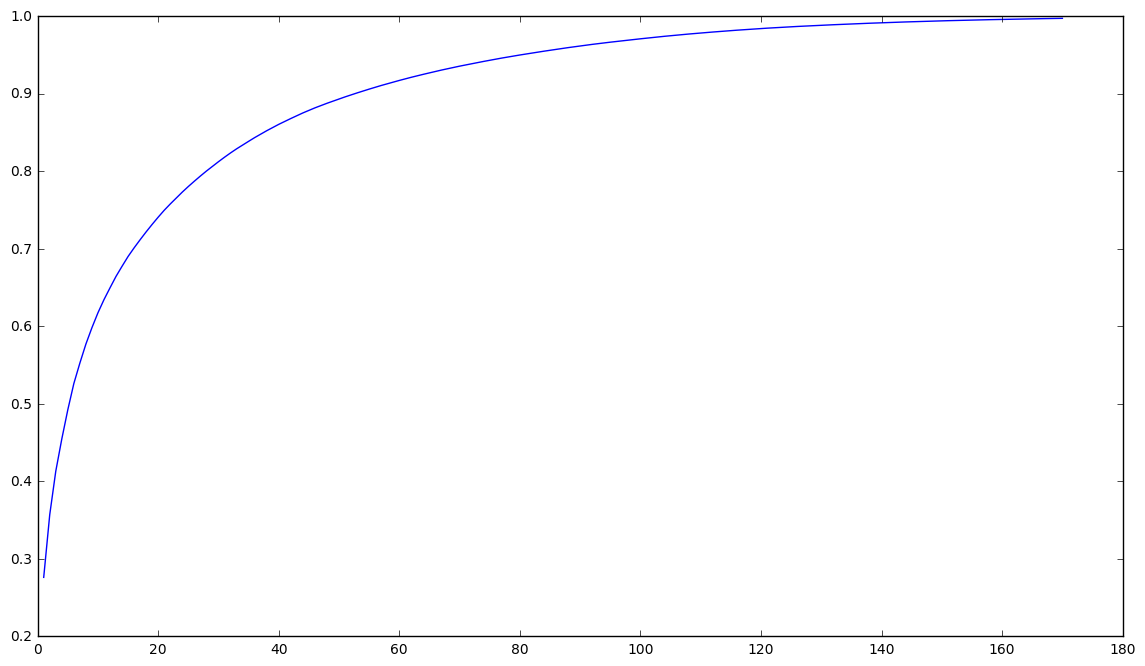

In [28]:
fig = plt.figure(figsize=(14,8))
plt.plot(np.arange(1, len(np.cumsum(pca.explained_variance_ratio_))+1, 1)[:170], 
         np.cumsum(pca.explained_variance_ratio_)[:170])

plt.show

It looks like from the plot above that it would take more than 100 PCs for the cumulative explained variance ratio reache 0.99 (our arbitrary cutoff). We will use another technique to reduce the dimensionality of the engineered data set prior to classification, which will make the resulting set of features easier to understand (e.g. what types of engineered features might be more important).

In [29]:
arr_final_df.to_csv('engineered_features.csv', sep=',',  index=False)